In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
from src.datagen.spatial import SpatialDataset
import torch
from torch.utils import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
Xtrain = torch.Tensor(pd.read_csv("../data/Xtrain.csv").values)
Ytrain = torch.Tensor(pd.read_csv("../data/Ytrain.csv").values)
Xtest = torch.Tensor(pd.read_csv("../data/Xtest.csv").values)
Ytest = torch.Tensor(pd.read_csv("../data/Ytest.csv").values)

In [29]:
spatialDataset = SpatialDataset(Xtrain, Ytrain, 30, 20, 10)

num_context:  16 num_target:  22


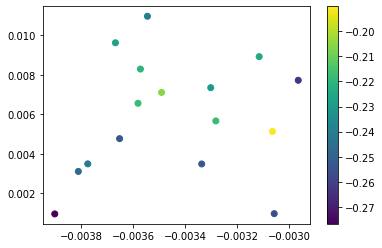

In [30]:
X_context, Y_context, X_target, Y_target = spatialDataset.generate()
print("num_context: ", X_context.shape[1], "num_target: ", X_target.shape[1])
plt.scatter(X_context[0,:,0].data, X_context[0,:,1].data, c=Y_context[0,:,:].data)
plt.colorbar()

In [31]:
Y_context[0], Y_target[0]

(tensor([[-0.2567],
         [-0.2479],
         [-0.2637],
         [-0.2533],
         [-0.2407],
         [-0.2298],
         [-0.2277],
         [-0.2202],
         [-0.2402],
         [-0.2182],
         [-0.2181],
         [-0.2529],
         [-0.2055],
         [-0.1901],
         [-0.2245],
         [-0.2768]]),
 tensor([[-0.2567],
         [-0.2479],
         [-0.2637],
         [-0.2533],
         [-0.2407],
         [-0.2298],
         [-0.2277],
         [-0.2202],
         [-0.2402],
         [-0.2182],
         [-0.2181],
         [-0.2529],
         [-0.2055],
         [-0.1901],
         [-0.2245],
         [-0.2768],
         [-2.4861],
         [-9.3428],
         [-3.4625],
         [-3.5329],
         [-3.0899],
         [ 4.4805]]))

# Train

Iter: 0, loss: 12.152941703796387


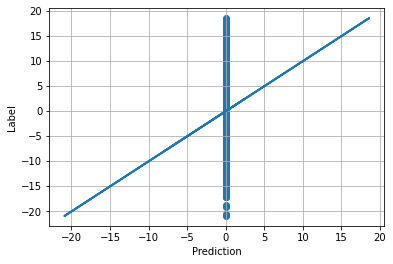

KeyboardInterrupt: 

In [28]:
from src.decoder import HeteroskedasticDecoder
from src.encoder import LatentEncoder, DeterministicEncoder
from src.aggregator import Attention
from src.neural_process import AttentiveNeuralProcess
from src.datagen.spatial import SpatialDataset

import torch
import torch.optim as optim
from torch.utils import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# argparse this
MAX_NUM_CONTEXT = 400
MAX_NUM_EXTRA_TARGET = 100
BATCH_SIZE = 30
EPOCHS = 5001
PLOT_AFTER = 500

# CSV names saved wrong way around, need fixing
xtest = torch.Tensor(pd.read_csv("../data/Xtrain.csv").values)
ytest = torch.Tensor(pd.read_csv("../data/Ytrain.csv").values)
xtrain = torch.Tensor(pd.read_csv("../data/Xtest.csv").values)
ytrain = torch.Tensor(pd.read_csv("../data/Ytest.csv").values)
trainDataset = SpatialDataset(xtrain, ytrain, BATCH_SIZE, MAX_NUM_CONTEXT, MAX_NUM_EXTRA_TARGET)
testDataset = SpatialDataset(xtest, ytest, BATCH_SIZE, MAX_NUM_CONTEXT, MAX_NUM_EXTRA_TARGET)

# define model
# Sizes of the layers of the MLPs for the encoders and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
x_dim = 2
y_dim = 1
r_dim = 32
z_dim = 32
hid_dim = 64
num_hid = 3
detencoder = DeterministicEncoder(x_dim, y_dim, r_dim, hid_dim=hid_dim, num_hid=num_hid)
latencoder = LatentEncoder(x_dim, y_dim, z_dim, hid_dim=hid_dim, num_hid=num_hid)
decoder = HeteroskedasticDecoder(x_dim, r_dim + z_dim, y_dim, hid_dim=hid_dim, num_hid=2)
att = Attention('identity','uniform', x_dim, r_dim, hid_dim=hid_dim, num_hid=num_hid)
model = AttentiveNeuralProcess(detencoder, att, latencoder, decoder, True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    epoch_loss = 0
    # Train dataset
    x_context, y_context, x_target, y_target = trainDataset.generate()
#     x_context = x_context.cuda()
#     y_context = y_context.cuda()
#     x_target = x_target.cuda()
#     y_target = y_target.cuda()

    # compute loss and backpropagate
    optimizer.zero_grad()
    y_pred_target_mu, y_pred_target_sigma, loss, _, _ = model.forward(x_context, y_context, x_target, y_target)
    loss.backward()
    optimizer.step()
    
    if epoch % PLOT_AFTER == 0:
        print(
            f"Iter: {epoch}, loss: {loss}"
        )
#         model.eval()
        y_target_mu, y_target_sigma, _, _, _ = model.forward(xtest.unsqueeze(0), ytest.unsqueeze(0), 
                                                             xtest.unsqueeze(0), ytest.unsqueeze(0))
        plt.figure()
        plt.plot(ytest.view(-1).data, ytest.view(-1).data, linewidth=2)
        plt.scatter(y_target_mu.view(-1).data, ytest.view(-1).data)
        plt.xlabel("Prediction")
        plt.ylabel("Label")
        plt.grid("off")
        plt.gca()
        plt.show()